## To run this colab, press the "Runtime" button in the menu tab and then press the "Run all" button.

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Recognize Cats using Transfer Learning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/community/en/flowers_tf_lite.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/community/en/flowers_tf_lite.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [ ]:
import tensorflow as tf
assert tf.__version__.startswith('2')

import os
import pandas as pd
import numpy as np
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [ ]:
tf.__version__

'2.2.0'

## Setup Input Pipeline

Download the cats dataset.

In [ ]:
_URL = "https://dl.dropbox.com/s/406optki5aagpu3/jenis2_kucing.zip?dl=2"

zip_file = tf.keras.utils.get_file(origin=_URL, 
                                   fname="jenis2_kucing.zip", 
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'jenis2_kucing')

18579456/18571641 [==============================] - 1s 0us/step


In [ ]:
base_dir

'/root/.keras/datasets/jenis2_kucing'

Use `ImageDataGenerator` to rescale the images.

Create the train generator and specify where the train dataset directory, image size, batch size.

Create the validation generator with similar approach as the train generator with the flow_from_directory() method.

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 2234 images belonging to 5 classes.
Found 557 images belonging to 5 classes.


In [ ]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 5))

Save the labels in a file which will be downloaded later.

In [ ]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'angora_cat': 0, 'norwegian_forest': 1, 'persian_cat': 2, 'siamese_cat': 3, 'sphynx_cat': 4}


In [ ]:
!cat labels.txt

angora_cat
norwegian_forest
persian_cat
siamese_cat
sphynx_cat

## Create the base model from the pre-trained convnets

Create the base model from the **MobileNet V2** model developed at Google, and pre-trained on the ImageNet dataset, a large dataset of 1.4M images and 1000 classes of web images.

First, pick which intermediate layer of MobileNet V2 will be used for feature extraction. A common practice is to use the output of the very last layer before the flatten operation, the so-called "bottleneck layer". The reasoning here is that the following fully-connected layers will be too specialized to the task the network was trained on, and thus the features learned by these layers won't be very useful for a new task. The bottleneck features, however, retain much generality.

Let's instantiate an MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the `include_top=False` argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


## Feature extraction
You will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

In [ ]:
base_model.trainable = False

### Add a classification head

In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(5, activation='softmax')
])

### Compile the model

You must compile the model before training it.  Since there are multiple classes, use a categorical cross-entropy loss.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 2,626,821
Trainable params: 368,837
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


### Train the model

<!-- TODO(markdaoust): delete steps_per_epoch in TensorFlow r1.14/r2.0 -->

In [ ]:
epochs = 30

history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=epochs, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator))

Epoch 1/30
35/35 [==============================] - 7s 191ms/step - loss: 0.8439 - accuracy: 0.7296 - val_loss: 0.4271 - val_accuracy: 0.8725
Epoch 2/30
35/35 [==============================] - 5s 156ms/step - loss: 0.4263 - accuracy: 0.8438 - val_loss: 0.3888 - val_accuracy: 0.8689
Epoch 3/30
35/35 [==============================] - 5s 155ms/step - loss: 0.3274 - accuracy: 0.8800 - val_loss: 0.3795 - val_accuracy: 0.8869
Epoch 4/30
35/35 [==============================] - 5s 155ms/step - loss: 0.2561 - accuracy: 0.9078 - val_loss: 0.4030 - val_accuracy: 0.8707
Epoch 5/30
35/35 [==============================] - 5s 154ms/step - loss: 0.1838 - accuracy: 0.9351 - val_loss: 0.3690 - val_accuracy: 0.8761
Epoch 6/30
35/35 [==============================] - 5s 155ms/step - loss: 0.1472 - accuracy: 0.9499 - val_loss: 0.3787 - val_accuracy: 0.8689
Epoch 7/30
35/35 [==============================] - 5s 153ms/step - loss: 0.1227 - accuracy: 0.9606 - val_loss: 0.4294 - val_accuracy: 0.8671
Epoch 

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor. 

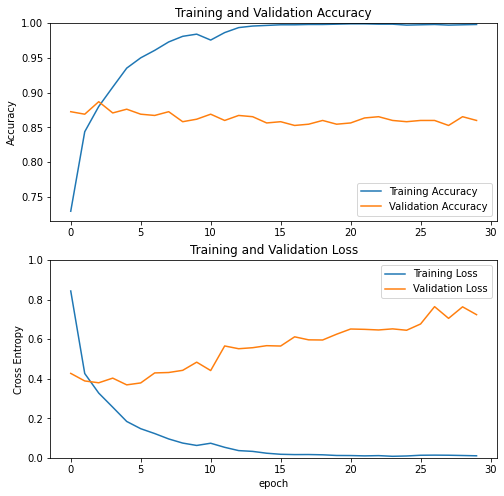

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning
In our feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic features maps to features associated specifically to our dataset.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers be un-trainable. Then, recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


### Compile the model

Compile the model using a much lower training rate.

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 2,626,821
Trainable params: 2,231,429
Non-trainable params: 395,392
_________________________________________________________________


In [ ]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 60


### Continue Train the model

In [ ]:
validation_steps=len(val_generator)

In [ ]:
history_fine = model.fit(train_generator, 
                         steps_per_epoch=len(train_generator), 
                         epochs=20, 
                         validation_data=val_generator, 
                         validation_steps=len(val_generator))

Epoch 1/20
35/35 [==============================] - 6s 185ms/step - loss: 1.0319 - accuracy: 0.7923 - val_loss: 0.8892 - val_accuracy: 0.8492
Epoch 2/20
35/35 [==============================] - 6s 163ms/step - loss: 0.5520 - accuracy: 0.8514 - val_loss: 0.8591 - val_accuracy: 0.8528
Epoch 3/20
35/35 [==============================] - 6s 161ms/step - loss: 0.3478 - accuracy: 0.8988 - val_loss: 0.8822 - val_accuracy: 0.8546
Epoch 4/20
35/35 [==============================] - 6s 160ms/step - loss: 0.2197 - accuracy: 0.9297 - val_loss: 0.9217 - val_accuracy: 0.8492
Epoch 5/20
35/35 [==============================] - 6s 158ms/step - loss: 0.1639 - accuracy: 0.9423 - val_loss: 0.9218 - val_accuracy: 0.8456
Epoch 6/20
35/35 [==============================] - 6s 159ms/step - loss: 0.1239 - accuracy: 0.9539 - val_loss: 0.9348 - val_accuracy: 0.8492
Epoch 7/20
35/35 [==============================] - 6s 158ms/step - loss: 0.1182 - accuracy: 0.9606 - val_loss: 0.9540 - val_accuracy: 0.8456
Epoch 

## Convert to TFLite

Saved the model using `tf.saved_model.save` and then convert the saved model to a tf lite compatible format.

In [ ]:
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: save/fine_tuning/assets


Download the converted model and labels

In [ ]:
from google.colab import files

#files.download('model.tflite')
#files.download('labels.txt')

Let's take a look at the learning curves of the training and validation accuracy/loss, when fine tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


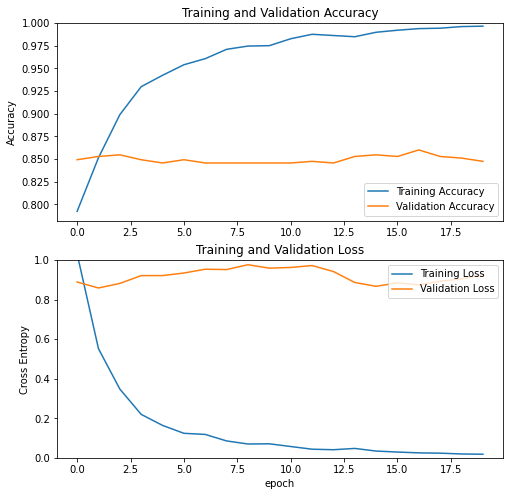

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Measure accuracy and loss after training

final_loss, final_accuracy = model.evaluate(val_generator, steps = validation_steps)

9/9 [==============================] - 1s 110ms/step - loss: 0.9254 - accuracy: 0.8474


In [ ]:
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

Final loss: 0.93
Final accuracy: 84.74%


In [ ]:
# Get images and labels batch from validation dataset generator

val_image_batch, val_label_batch = next(iter(val_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (64, 224, 224, 3)


In [ ]:
#load model
cats_model = hub.load(saved_model_dir)
print(cats_model)

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f1b21398b38>


In [ ]:
tf_model_predictions = cats_model(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (64, 5)


In [ ]:
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Angora_Cat' 'Norwegian_Forest' 'Persian_Cat' 'Siamese_Cat' 'Sphynx_Cat']


In [ ]:
# Convert prediction results to Pandas dataframe, for better visualization

tf_pred_dataframe = pd.DataFrame(tf_model_predictions.numpy())
tf_pred_dataframe.columns = dataset_labels

print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,Angora_Cat,Norwegian_Forest,Persian_Cat,Siamese_Cat,Sphynx_Cat
0,9.999931e-01,1.082152e-11,6.861086e-06,3.253152e-09,4.701434e-11
1,9.544941e-01,8.591501e-12,4.550403e-02,1.787433e-06,2.076530e-10
2,8.516289e-08,2.304867e-12,1.280468e-07,9.999998e-01,9.841932e-10
3,2.170550e-06,1.351808e-05,1.949273e-06,2.759805e-07,9.999821e-01
4,2.167973e-08,3.516806e-05,2.447506e-06,1.769262e-06,9.999605e-01


In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

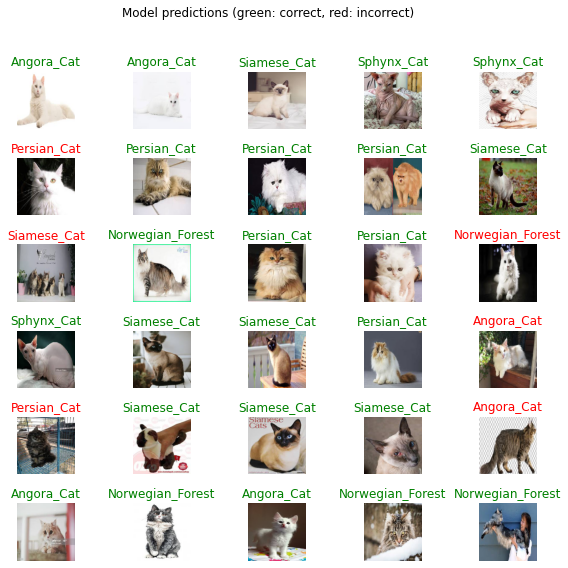

In [ ]:
# Print images batch and labels predictions

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Summary:

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is common to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the orginial dataset that the pre-trained model was trained on.
